<a href="https://colab.research.google.com/github/progameshop1/CVD/blob/main/MITB_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries



In [ ]:
# install PhysioNet ecg data package
!pip install wfdb
!pip install --upgrade google-cloud-storage
#Import Necessary Packages
import os
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import auth
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Authenticate and set up Google Cloud
auth.authenticate_user()
# Set the Google Cloud project
!gcloud config set project crested-bonfire-451902-u0

Updated property [core/project].


# Data Preparation

In [ ]:
# Download ECG data from PhysioNet
data_dir = '/content/mitdb-1.0.0.physionet.org'
if not os.path.exists(data_dir):
    !gsutil -u crested-bonfire-451902-u0 -m cp -r gs://mitdb-1.0.0.physionet.org /content/

In [ ]:
# Verify data download
try:
    print(os.listdir(data_dir))  # Check the contents of the 'mitdb' directory
except FileNotFoundError:
    print(f"Directory {data_dir} not found. Please check the data download step.")


['105.xws', 'ANNOTATORS', 'mitdbdir', '119.xws', '234.hea', '121.dat', '201.dat', '114.dat', '103.xws', '232.hea', '221.dat', '109.dat', '104.dat', '213.hea', '100.atr', '223.dat', '212.hea', '234.xws', '219.dat', '210.atr', '233.xws', '102.xws', '203.at_', '230.xws', '214.dat', '233.atr', '223.xws', '106.hea', '108.hea', '122.dat', '215.dat', '114.atr', '107.atr', '115.dat', '111.atr', '212.xws', '214.atr', '104.atr', '116.dat', '232.xws', '103.atr', '201.xws', '123.xws', '117.xws', '105.hea', '214.hea', '232.atr', '123.dat', '217.atr', '118.atr', '112.xws', '209.hea', '104.hea', '219.hea', '113.hea', '231.hea', '101.xws', '200.xws', '215.hea', '233.hea', '223.atr', '123.hea', '215.xws', '116.xws', '111.dat', '114.hea', '228.atr', '215.at_', '219.atr', '121.atr', '220.atr', '102-0.atr', '202.hea', '122.xws', '210.xws', '121.hea', '119.dat', '117.atr', '119.hea', '122.hea', '220.xws', '111.xws', 'mit-bih-arrhythmia-database-1.0.0.zip', '202.dat', '123.atr', '124.xws', '213.xws', '223.h

In [ ]:
# Load ECG record and annotations
record_name = '100'
record_path = os.path.join(data_dir, record_name)
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')


In [ ]:
#Segmentation into Windows
def create_windows(signal, window_size, step_size):
    windows = []
    for start in range(0, len(signal) - window_size, step_size):
        windows.append(signal[start:start + window_size])
    return np.array(windows)

window_size = 128  # Number of samples per window
step_size = 64     # Overlap or step between windows
ecg_windows = create_windows(record.p_signal[:, 0], window_size, step_size)  # First channel

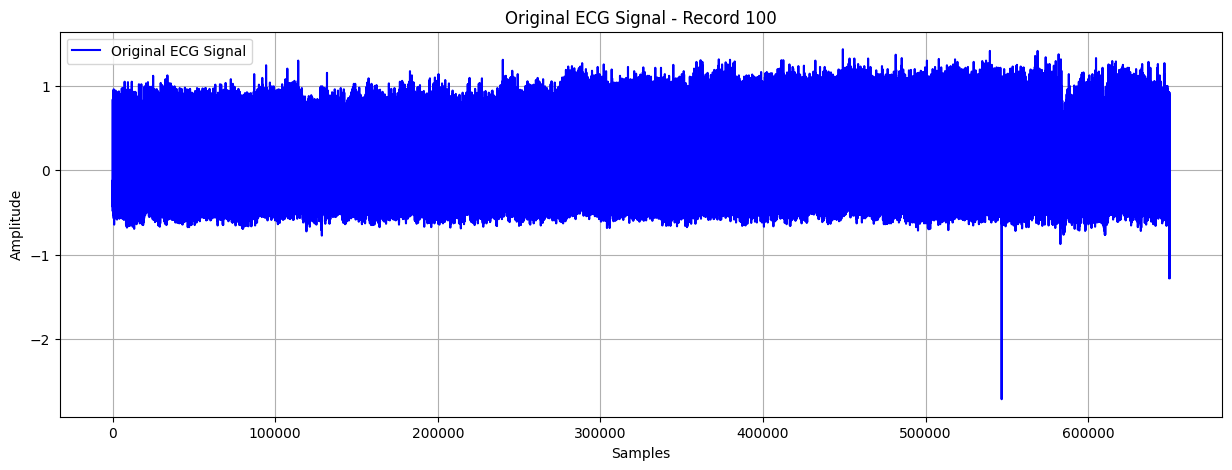

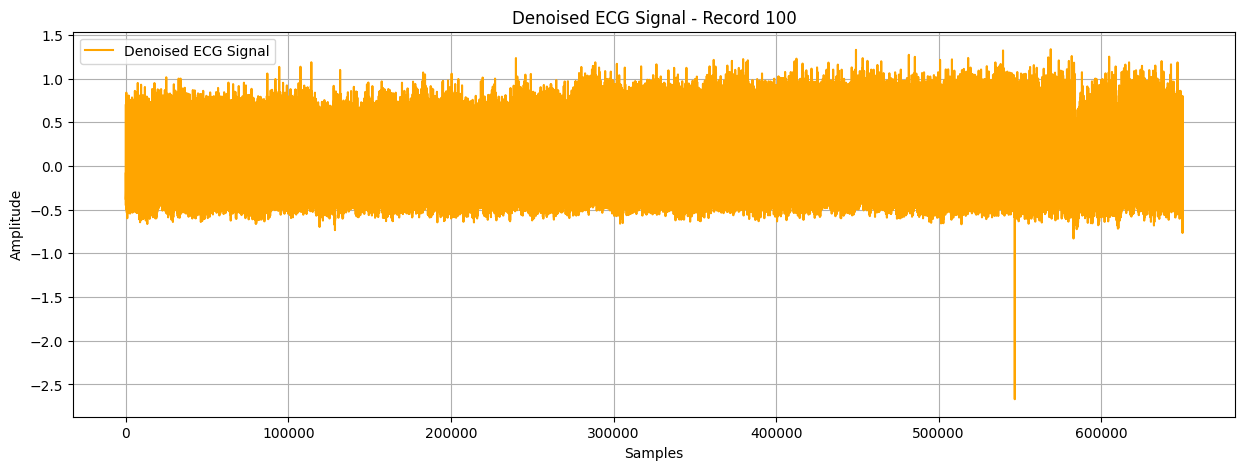

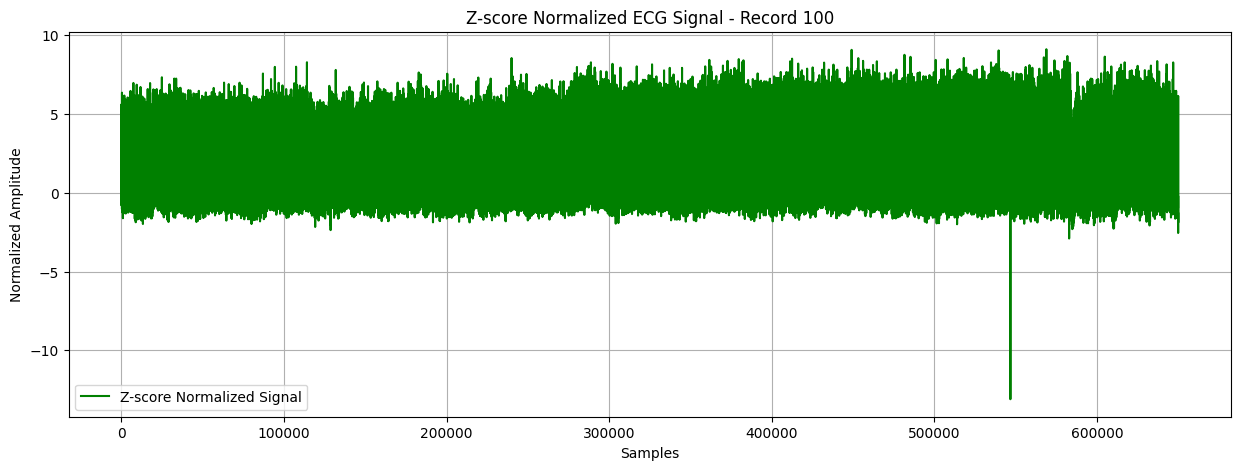

In [ ]:
# Get the first channel of the ECG signal
ecg_signal = record.p_signal[:, 0]

# Plot the original ECG signal
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal, label='Original ECG Signal', color='blue')
plt.title('Original ECG Signal - Record 100')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

# Denoising the signal (simple moving average as an example)
window_size = 5
denoised_signal = np.convolve(ecg_signal, np.ones(window_size) / window_size, mode='same')

# Plot the denoised signal
plt.figure(figsize=(15, 5))
plt.plot(denoised_signal, label='Denoised ECG Signal', color='orange')
plt.title('Denoised ECG Signal - Record 100')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

# Z-score normalization
mean = np.mean(denoised_signal)
std = np.std(denoised_signal)
z_score_normalized_signal = (denoised_signal - mean) / std

# Plot the Z-score normalized signal
plt.figure(figsize=(15, 5))
plt.plot(z_score_normalized_signal, label='Z-score Normalized Signal', color='green')
plt.title('Z-score Normalized ECG Signal - Record 100')
plt.xlabel('Samples')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Normalization
scaler = MinMaxScaler()
ecg_windows = scaler.fit_transform(ecg_windows.reshape(-1, ecg_windows.shape[-1])).reshape(ecg_windows.shape)

In [ ]:
# Labeling the Data
labels = []
for window_start in range(0, len(record.p_signal[:, 0]) - window_size, step_size):
    label = None
    for start in range(0, len(annotation.sample) - 1):
        if window_start <= annotation.sample[start] < window_start + window_size:
            label = annotation.symbol[start]  # Assign label based on the annotation
            break
    labels.append(label)  # Append the label for this window

In [ ]:
# Reshaping Data for LSTM
X = ecg_windows.reshape((ecg_windows.shape[0], ecg_windows.shape[1], 1))  # Add a dimension for features
y = np.array(labels)  # Ensure labels are in the correct format

In [ ]:
# Check for None values in y and replace them with 'Unknown'
y_cleaned = np.array(['Unknown' if label is None else label for label in y])

# Encode string labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_cleaned)

# Verify the encoded labels
print("Encoded labels:", y_encoded)
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))



Encoded labels: [0 2 3 ... 2 3 3]
Class mapping: {'+': 0, 'A': 1, 'N': 2, 'Unknown': 3, 'V': 4}


In [ ]:
# Check class distribution in y_encoded
class_distribution = Counter(y_encoded)
print("Class distribution in y_encoded:", class_distribution)

# Identify classes with fewer than 2 samples
invalid_classes = [cls for cls, count in class_distribution.items() if count < 2]
print("Invalid classes (fewer than 2 samples):", invalid_classes)

# Filter out rows corresponding to invalid classes
mask = ~np.isin(y_encoded, invalid_classes)
X_filtered = X[mask]
y_filtered = y_encoded[mask]

# Verify the filtered data
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y_filtered: {y_filtered.shape}")

# Split the filtered data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)


Class distribution in y_encoded: Counter({3: 5611, 2: 4475, 1: 66, 4: 2, 0: 1})
Invalid classes (fewer than 2 samples): [0]
Shape of X_filtered: (10154, 128, 1)
Shape of y_filtered: (10154,)


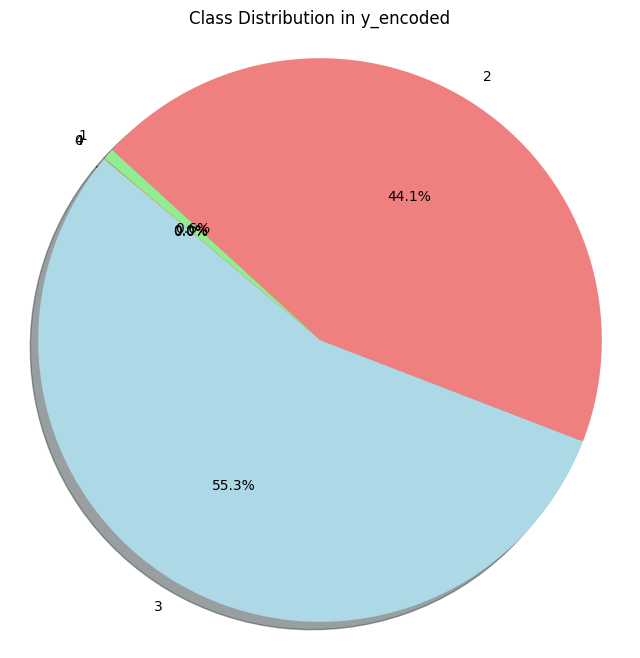

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Class distribution from your output
class_distribution = Counter({3: 5611, 2: 4475, 1: 66, 4: 2, 0: 1})

# Prepare data for the pie chart
labels = list(class_distribution.keys())
sizes = list(class_distribution.values())
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'gold']  # Customize colors as needed

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Class Distribution in y_encoded')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

In [ ]:
# Update the model's output layer for multi-class classification
num_classes = len(label_encoder.classes_)
model = Sequential([
    LSTM(64, input_shape=(window_size, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model with categorical_crossentropy
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Proceed with model training and evaluation
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.5016 - loss: 0.9125 - val_accuracy: 0.5524 - val_loss: 0.7331
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.5142 - loss: 0.7393 - val_accuracy: 0.5524 - val_loss: 0.7257
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - accuracy: 0.5315 - loss: 0.7400 - val_accuracy: 0.5524 - val_loss: 0.7252
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.5527 - loss: 0.7347 - val_accuracy: 0.4407 - val_loss: 0.7319
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.5362 - loss: 0.7298 - val_accuracy: 0.5524 - val_loss: 0.7258
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.5491 - loss: 0.7220 - val_accuracy: 0.5524 - val_loss: 0.7253
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 39s 121ms/step - accuracy: 0.5498 - loss: 0.7329 - val_accuracy: 0.5524 - val_loss: 0.7264
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.5481 - loss: 0

In [ ]:
# Save the entire model
model.save('ecg_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('ecg_model.h5')

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9874 - loss: 0.0745
Test Loss: 0.0627
Test Accuracy: 0.9872


In [ ]:
model = Sequential([
    LSTM(128, input_shape=(window_size, 1), return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

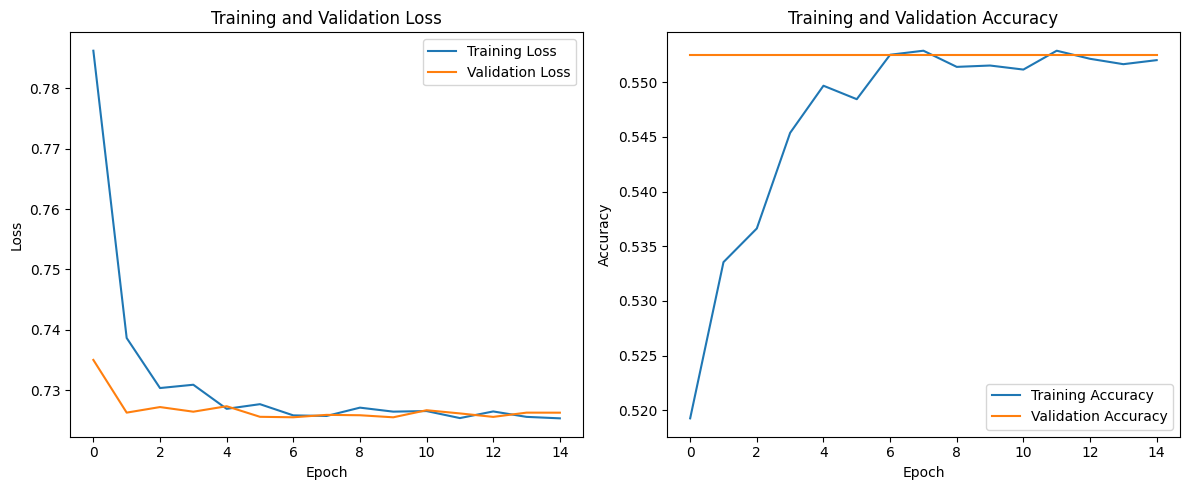

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5121 - loss: 0.8832

254/254 ━━━━━━━━━━━━━━━━━━━━ 92s 342ms/step - accuracy: 0.5121 - loss: 0.8828 - val_accuracy: 0.5524 - val_loss: 0.7350
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5351 - loss: 0.7449

254/254 ━━━━━━━━━━━━━━━━━━━━ 141s 339ms/step - accuracy: 0.5351 - loss: 0.7449 - val_accuracy: 0.5524 - val_loss: 0.7263
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 86s 339ms/step - accuracy: 0.5299 - loss: 0.7379 - val_accuracy: 0.5524 - val_loss: 0.7272
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 137s 318ms/step - accuracy: 0.5437 - loss: 0.7266 - val_accuracy: 0.5524 - val_loss: 0.7265
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 86s 338ms/step - accuracy: 0.5495 - loss: 0.7302 - val_accuracy: 0.5524 - val_loss: 0.7274
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5469 - loss: 0.7325

254/254 ━━━━━━━━━━━━━━━━━━━━ 142s 339ms/step - accuracy: 0.5469 - loss: 0.7325 - val_accuracy: 0.5524 - val_loss: 0.7256
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5588 - loss: 0.7200

254/254 ━━━━━━━━━━━━━━━━━━━━ 142s 338ms/step - accuracy: 0.5588 - loss: 0.7201 - val_accuracy: 0.5524 - val_loss: 0.7255
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 142s 338ms/step - accuracy: 0.5611 - loss: 0.7248 - val_accuracy: 0.5524 - val_loss: 0.7259
Epoch 9/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 137s 320ms/step - accuracy: 0.5535 - loss: 0.7282 - val_accuracy: 0.5524 - val_loss: 0.7259
Epoch 10/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5350 - loss: 0.7252

254/254 ━━━━━━━━━━━━━━━━━━━━ 85s 336ms/step - accuracy: 0.5351 - loss: 0.7252 - val_accuracy: 0.5524 - val_loss: 0.7255
Epoch 11/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 143s 341ms/step - accuracy: 0.5556 - loss: 0.7252 - val_accuracy: 0.5524 - val_loss: 0.7267
Epoch 12/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 0.5530 - loss: 0.7187 - val_accuracy: 0.5524 - val_loss: 0.7262
Epoch 13/50
205/254 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.5571 - loss: 0.7255

In [ ]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Print some predictions
print("Predicted Classes:", y_pred_classes[:10])
print("True Classes:", y_test[:10])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

In [ ]:
from sklearn.model_selection import KFold

# Define K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
for train_idx, val_idx in kfold.split(X_filtered):
    X_train, X_val = X_filtered[train_idx], X_filtered[val_idx]
    y_train, y_val = y_filtered[train_idx], y_filtered[val_idx]

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')